In [127]:
import pandas as pd
import pandas as pd
import networkx as nx
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch
from networkx.algorithms import community as nx_community
from sklearn.cluster import SpectralClustering
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from collections import defaultdict, Counter
from community import community_louvain
from community import community_louvain
from sklearn.cluster import SpectralClustering
import community as community_louvain
from collections import defaultdict
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la


In [128]:
df = pd.read_csv("data/primaryschool_cleaned.csv",delimiter="\t",header=None)
df.head()

0     1     2   3   4
0  31220  1558  1567  3B  3B
1  31220  1560  1570  3B  3B
2  31220  1567  1574  3B  3B
3  31220  1632  1818  4B  4B
4  31220  1632  1866  4B  4B

# Construction du réseau entre les classes

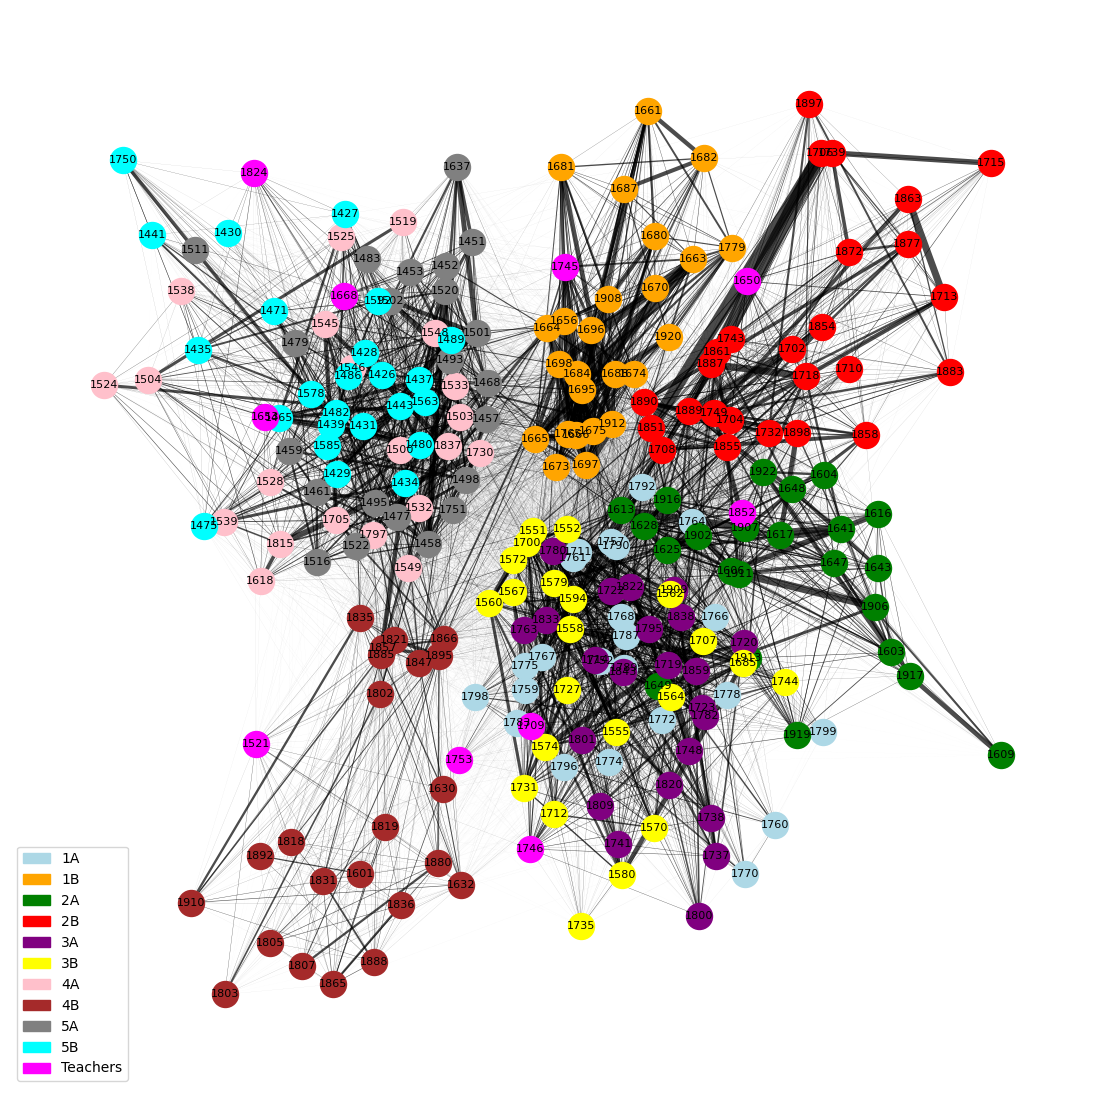

In [129]:
G = nx.Graph()

# Construction du graphe
for (i, j), group in df.groupby([1, 2]):
    Si, Sj = group[3].iloc[0], group[4].iloc[0]   # catégories
    total_t = group[0].sum()                       # somme des temps de contact

    # Ajouter les noeuds et arêtes
    G.add_nodes_from([
        (i, {"category": Si}),
        (j, {"category": Sj})
    ])
    G.add_edge(i, j, t=total_t)

# Coloration des noeuds par catégories

color_map = {
    "1A": "lightblue",   
    "1B": "orange",      
    "2A": "green",     
    "2B": "red",
    "3A": "purple",
    "3B": "yellow",
    "4A": "pink",
    "4B": "brown",
    "5A": "gray",
    "5B": "cyan",
    "Teachers": "magenta"
    
}
node_colors = [color_map.get(G.nodes[n]["category"], "black") for n in G.nodes()]

# Layout du graphe

pos = nx.spring_layout(G, seed=42)  # Calculer le layout une seule fois

# Ponderation sur les arêtes

edge_weights = [G[u][v]["t"] for u, v in G.edges()]
max_w = max(edge_weights) or 1
edge_widths = [10 * (w / max_w) for w in edge_weights]

# Construction  du graphe

plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7)
for cat, color in color_map.items():
    nodes = [n for n, attr in G.nodes(data=True) if attr["category"] == cat]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=350, label=cat)

nx.draw_networkx_labels(G, pos, font_size=8)

# Ajouter la légende
legend_handles = [mpatches.Patch(color=color, label=cat) for cat, color in color_map.items()] # Créer des patches pour la légende(rectangles de couleur)
plt.legend(handles=legend_handles, loc='best')
plt.axis("off")
plt.show()

# Dégré de distribution

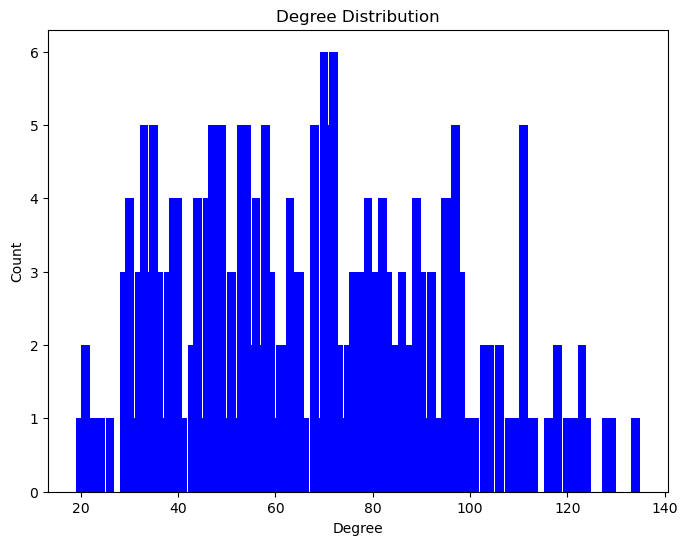

In [130]:
# Degré de chaque noeud
degree_sequence = [d for n, d in G.degree()]

# Distribution des degrés
degree_count = Counter(degree_sequence)
deg, cnt = zip(*degree_count.items())

plt.figure(figsize=(8, 6))
plt.bar(deg, cnt, width=1.8, color='blue')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Calcul des propriétés du graphe

In [131]:
# Calcul des principales mesures de centralité du graphe

degree = dict(G.degree(weight="t"))

betw = nx.betweenness_centrality(G, weight="t", normalized=True)

G_for_closeness = G.copy()
for u, v, d in G_for_closeness.edges(data=True):
    d["inv_t"] = 1 / d["t"]

close = nx.closeness_centrality(G_for_closeness, distance="inv_t")

pagerank = nx.pagerank(G, weight="t")

avg_neigh_deg = nx.average_neighbor_degree(G, weight="t")

katz = nx.katz_centrality_numpy(G, weight="t", alpha=0.1, beta=1.0) 

df_cent = pd.DataFrame({
    "node": list(G.nodes()),
    "category": [G.nodes[n]["category"] for n in G.nodes()],
    "degree": [degree[n] for n in G.nodes()],
    "betweenness": [betw[n] for n in G.nodes()],
    "closeness": [close[n] for n in G.nodes()],
    "pagerank": [pagerank[n] for n in G.nodes()],
    "avg_neighbor_degree": [avg_neigh_deg[n] for n in G.nodes()],
    "katz": [katz[n] for n in G.nodes()]
})

df_cent.head()

node category    degree  betweenness     closeness  pagerank  \
0  1426       5B  91508200     0.000726  1.580695e+06  0.004511   
1  1427       5B  61967460     0.000346  1.451150e+06  0.003197   
2  1428       5B  56009580     0.005066  1.409434e+06  0.002910   
3  1429       5B  91715660     0.009682  1.407795e+06  0.004469   
4  1430       5B   8642180     0.007158  6.767248e+05  0.001008   

   avg_neighbor_degree      katz  
0            74.572172  0.107259  
1            73.275396  0.071321  
2            80.567970 -0.235038  
3            75.425789  0.007972  
4            68.867439  0.404026

Clustering

In [132]:
def clustering_stats_by_category(G):
    clust = nx.clustering(G)
    # Regrouper les noeuds par catégorie
    categories = {}
    for node in G.nodes():
        cat = G.nodes[node].get("category", None)
        if cat is None:
            continue
        if cat not in categories:
            categories[cat] = []
        categories[cat].append(clust[node])
    avg_by_cat = {cat: sum(vals) / len(vals) for cat, vals in categories.items()}
    return avg_by_cat

stats_by_cat = clustering_stats_by_category(G)

print("Clustering moyen par catégorie :")
for cat, val in stats_by_cat.items():
    print(f"  {cat}: {val:.4f}")


Clustering moyen par catégorie :
  5B: 0.5685
  5A: 0.5123
  4A: 0.5433
  3B: 0.5091
  2A: 0.5098
  4B: 0.5153
  1B: 0.4887
  2B: 0.5817
  1A: 0.4901
  3A: 0.5366
  Teachers: 0.5122


Visualisation des clusters

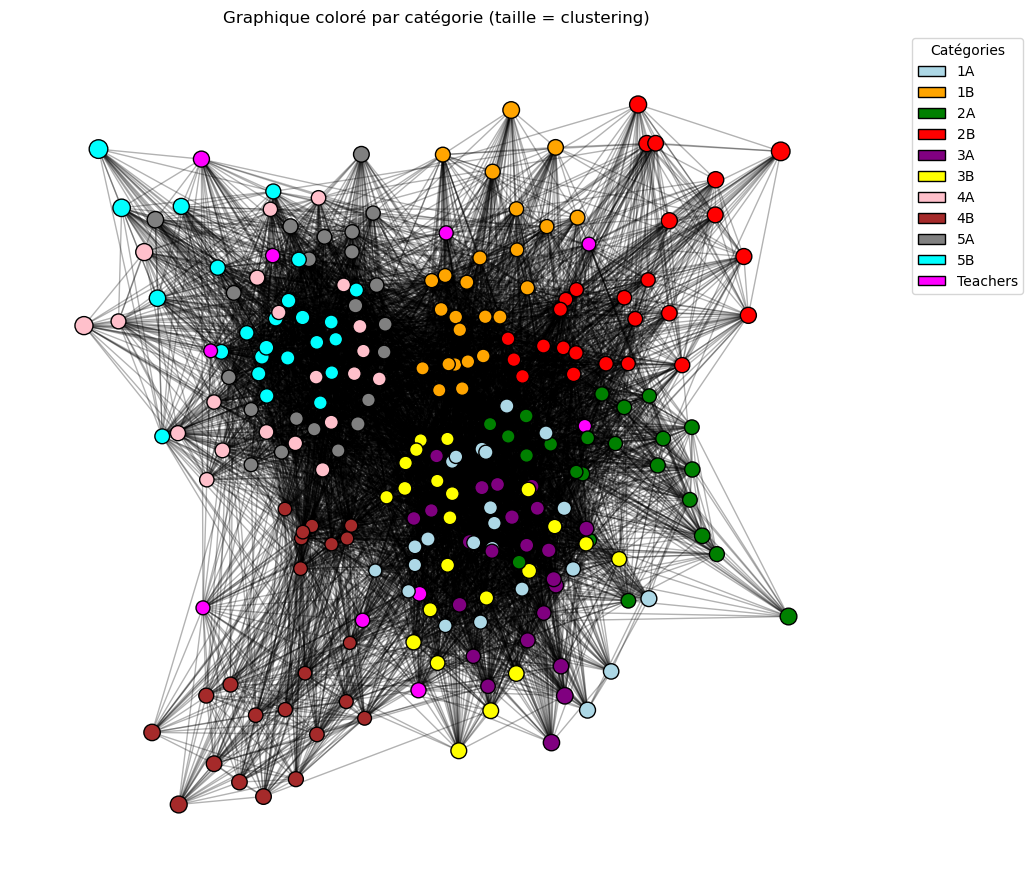

In [133]:
# Your color map
color_map = {
    "1A": "lightblue",
    "1B": "orange",
    "2A": "green",
    "2B": "red",
    "3A": "purple",
    "3B": "yellow",
    "4A": "pink",
    "4B": "brown",
    "5A": "gray",
    "5B": "cyan",
    "Teachers": "magenta"
}

# Compute clustering coefficients
clust = nx.clustering(G)

# Extract node colors based on category
node_colors = []
for n in G.nodes():
    cat = G.nodes[n].get("category", None)
    node_colors.append(color_map.get(cat, "black"))  # fallback color if missing

# Optionally: node size proportional to clustering
node_sizes = [30 + 150 * clust[n] for n in G.nodes()]

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(11, 11))

nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black"
)

nx.draw_networkx_edges(G, pos, alpha=0.3)

legend_elements = [
    Patch(facecolor=color_map[c], edgecolor="black", label=c)
    for c in color_map
]

plt.legend(
    handles=legend_elements,
    title="Catégories",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.title("Graphique coloré par catégorie (taille = clustering)")
plt.axis("off")
plt.show()




# Model de réseau

Réseau réel : Clustering=0.0072, Modularité=0.6731
ER : Clustering=0.2857, Modularité=0.0799
BA : Clustering=0.3324, Modularité=0.0845
WS : Clustering=0.5735, Modularité=0.3959


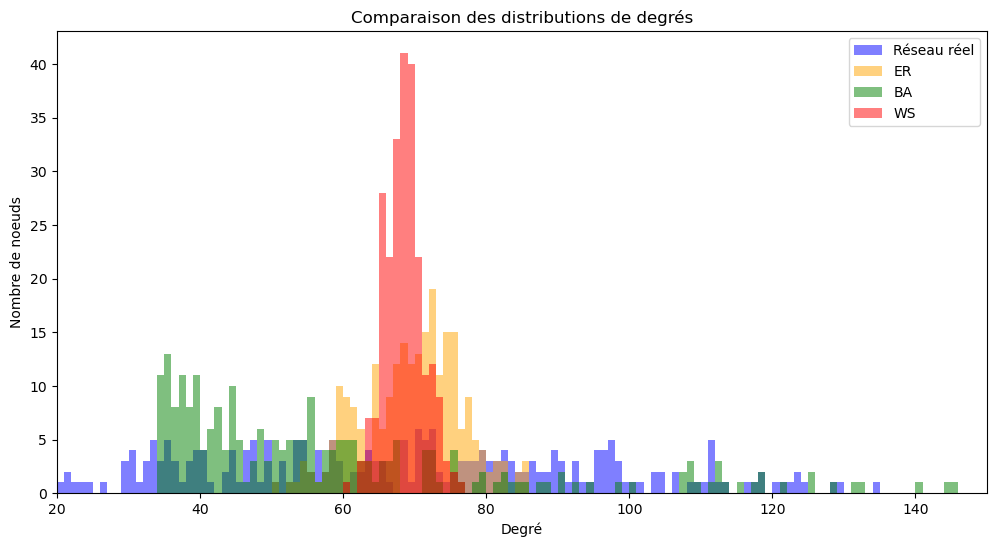

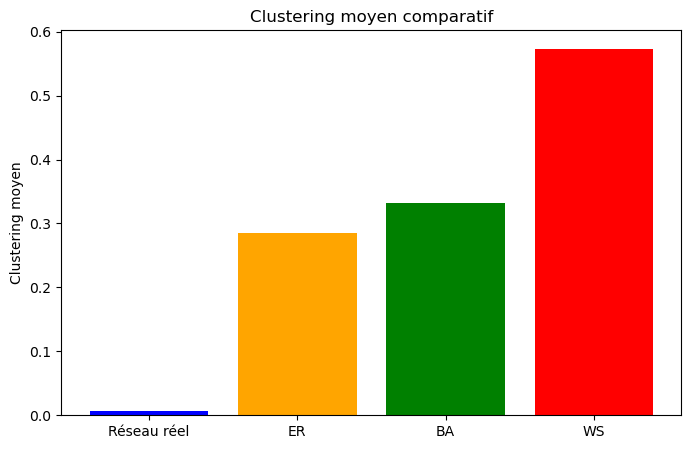

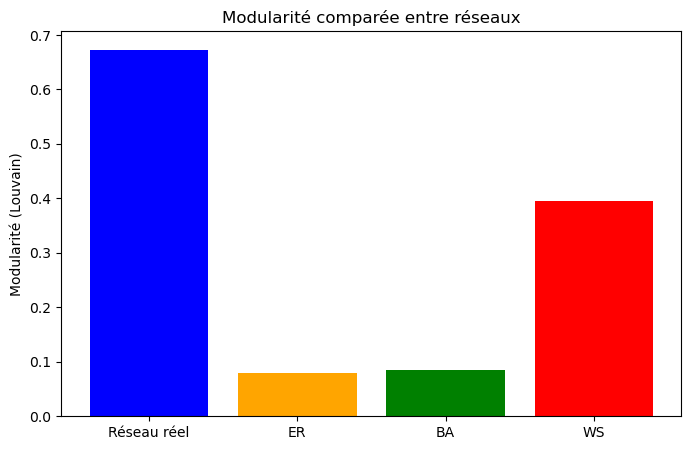

In [134]:
#1 Grapahe G avec une   modularité de  Louvain 
G_real = G 
n_nodes = G_real.number_of_nodes()
n_edges = G_real.number_of_edges()

partition_real = community_louvain.best_partition(G_real, weight='t')
mod_real = community_louvain.modularity(partition_real, G_real, weight='t')
clust_real = nx.average_clustering(G_real, weight='t')
degrees_real = [d for n, d in G_real.degree()]

print(f"Réseau réel : Clustering={clust_real:.4f}, Modularité={mod_real:.4f}")

#2 Random graph models [Réseau Erdos-Rényi, ER]

p_er = 2 * n_edges / (n_nodes*(n_nodes-1))  # probabilité pour un  même nombre d'arêtes
G_er = nx.erdos_renyi_graph(n_nodes, p_er)
partition_er = community_louvain.best_partition(G_er)
mod_er = community_louvain.modularity(partition_er, G_er)
clust_er = nx.average_clustering(G_er)
degrees_er = [d for n, d in G_er.degree()]
print(f"ER : Clustering={clust_er:.4f}, Modularité={mod_er:.4f}")

#3.1 Mechanistic models [Réseau Barabási-Albert, BA]

m_ba = int(n_edges / n_nodes)  # nombre d'arêtes à attacher par nouveau noeud
G_ba = nx.barabasi_albert_graph(n_nodes, m_ba)
partition_ba = community_louvain.best_partition(G_ba)
mod_ba = community_louvain.modularity(partition_ba, G_ba)
clust_ba = nx.average_clustering(G_ba)
degrees_ba = [d for n, d in G_ba.degree()]
print(f"BA : Clustering={clust_ba:.4f}, Modularité={mod_ba:.4f}")

# 3.2 Mechanistic models [Réseau Watts-Strogatz, WS]

k_ws = int(2*n_edges/n_nodes)  # nombre moyen de voisins
p_ws = 0.1  # probabilité de réorganisation
G_ws = nx.watts_strogatz_graph(n_nodes, k_ws, p_ws)
partition_ws = community_louvain.best_partition(G_ws)
mod_ws = community_louvain.modularity(partition_ws, G_ws)
clust_ws = nx.average_clustering(G_ws)
degrees_ws = [d for n, d in G_ws.degree()]
print(f"WS : Clustering={clust_ws:.4f}, Modularité={mod_ws:.4f}")


# Visualisation des dégres des trois modèles 

plt.figure(figsize=(12,6))
plt.hist(degrees_real, bins=range(max(degrees_real)+2), alpha=0.5, label="Réseau réel",color='blue')
plt.hist(degrees_er, bins=range(max(degrees_er)+2), alpha=0.5, label="ER",color='orange')
plt.hist(degrees_ba, bins=range(max(degrees_ba)+2), alpha=0.5, label="BA",color='green')
plt.hist(degrees_ws, bins=range(max(degrees_ws)+2), alpha=0.5, label="WS",color='red')
plt.xlabel("Degré")
plt.ylabel("Nombre de noeuds")
plt.title("Comparaison des distributions de degrés")
plt.xlim(20, 150)
plt.legend()
plt.show()

# Comparaison du clustering entre les trois modeles

clustering_values = [clust_real, clust_er, clust_ba, clust_ws]
labels = ["Réseau réel", "ER", "BA", "WS"]
plt.figure(figsize=(8,5))
plt.bar(labels, clustering_values, color=['blue','orange','green','red'])
plt.ylabel("Clustering moyen")
plt.title("Clustering moyen comparatif")
plt.show()

# Comparaison de la modularité entre les trois modeles
modularity_values = [mod_real, mod_er, mod_ba, mod_ws]
plt.figure(figsize=(8,5))
plt.bar(labels, modularity_values, color=['blue','orange','green','red'])
plt.ylabel("Modularité (Louvain)")
plt.title("Modularité comparée entre réseaux")
plt.show()


# Detection des communautés

Louvain Algorithm

Communauté 1 : 
  5B -> 24 individus
  5A -> 22 individus
  Teachers -> 2 individus
  4B -> 1 individus
Communauté 2 : 
  4A -> 21 individus
  4B -> 22 individus
  Teachers -> 2 individus
Communauté 3 : 
  3B -> 22 individus
  3A -> 23 individus
  Teachers -> 2 individus
Communauté 4 : 
  2A -> 23 individus
  Teachers -> 1 individus
Communauté 5 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 6 : 
  2B -> 26 individus
  Teachers -> 1 individus
Communauté 0 : 
  1A -> 23 individus
  Teachers -> 1 individus


/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_69689/1287966049.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


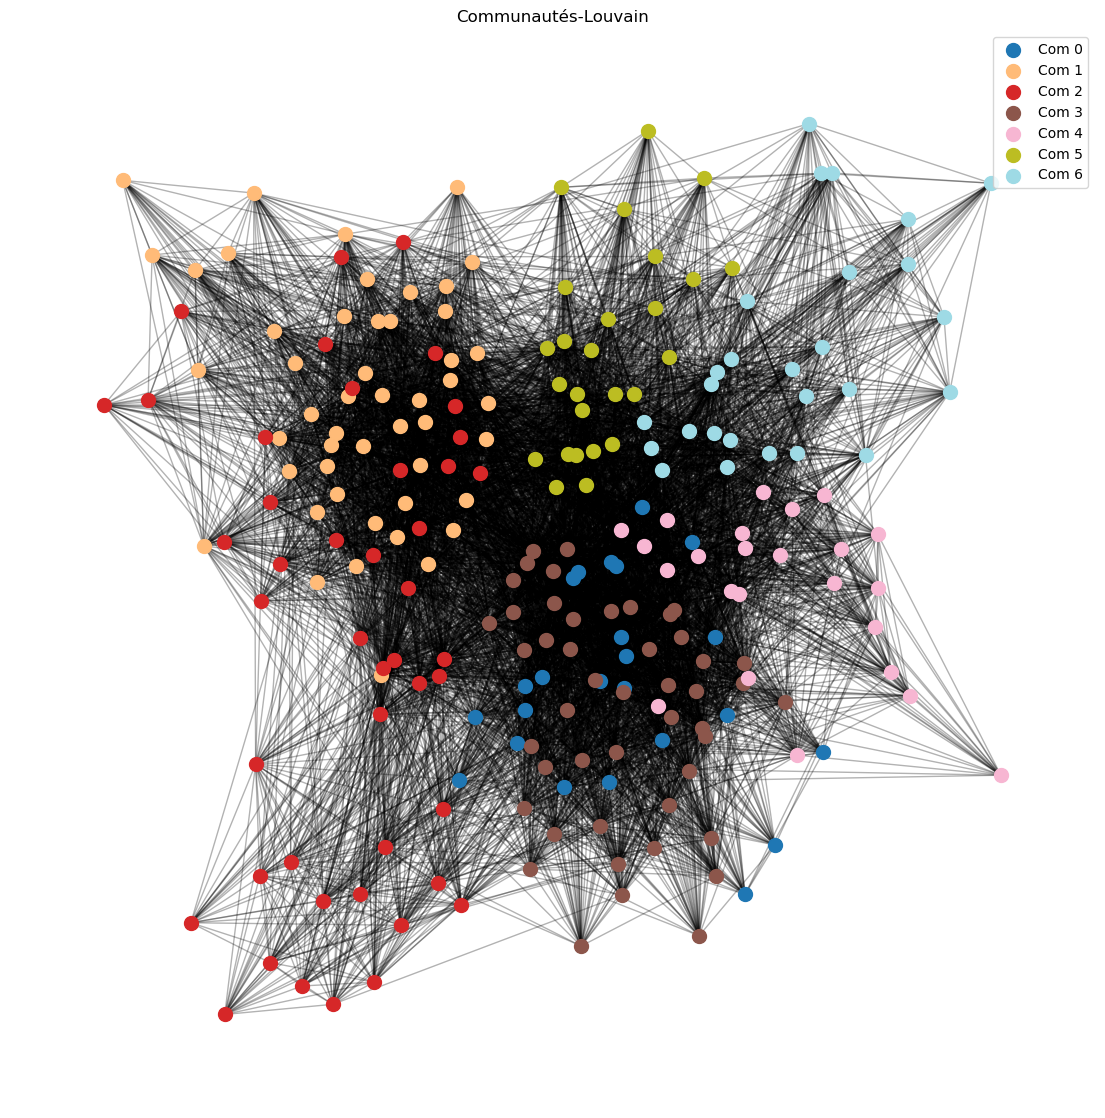

In [135]:
# Détection des communautés avec Louvain
partition_louvain = community_louvain.best_partition(G, weight='t')

# Analyse des catégories par communauté
def categories_per_community(G, partition):
    """
    G : graphe NetworkX
    partition : dict {node: community_index}
    Retourne : dict {community: Counter({category: count})}
    """
    comm_cat_count = defaultdict(Counter)
    for n in G.nodes():
        comm = partition[n]
        cat = G.nodes[n]['category']
        comm_cat_count[comm][cat] += 1
    return comm_cat_count


comm_categories_louvain = categories_per_community(G, partition_louvain)

# Afficher le nombre de categories par commaunauté
for comm, cat_count in comm_categories_louvain.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(14,14))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_louvain, "Communautés-Louvain")


Spectral

Modularité Spectral : -9.123174244341715
Communauté 4 : 
  5B -> 24 individus
  Teachers -> 1 individus
Communauté 7 : 
  5A -> 22 individus
  Teachers -> 1 individus
Communauté 2 : 
  4A -> 21 individus
  4B -> 3 individus
  Teachers -> 1 individus
Communauté 9 : 
  3B -> 22 individus
  Teachers -> 1 individus
Communauté 8 : 
  2A -> 23 individus
  Teachers -> 1 individus
Communauté 1 : 
  4B -> 20 individus
  Teachers -> 1 individus
Communauté 0 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 3 : 
  2B -> 22 individus
  Teachers -> 1 individus
Communauté 10 : 
  2B -> 4 individus
Communauté 5 : 
  1A -> 23 individus
  Teachers -> 1 individus
Communauté 6 : 
  3A -> 23 individus
  Teachers -> 1 individus


/opt/anaconda3/lib/python3.12/site-packages/networkx/algorithms/community/quality.py:253: RuntimeWarning: overflow encountered in scalar multiply
  return L_c / m - resolution * out_degree_sum * in_degree_sum * norm
/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_69689/626543414.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


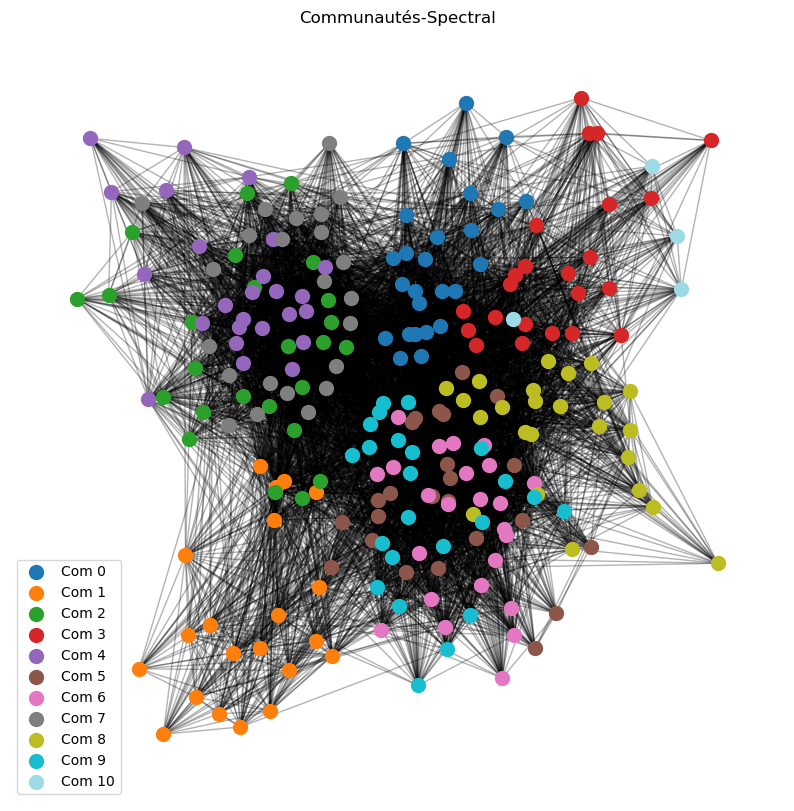

In [136]:

# Définir nombre de communautés (10 classes + Teachers)

k = 11
adj_matrix = nx.to_numpy_array(G, weight='t')
spectral = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
labels_spectral = spectral.fit_predict(adj_matrix)
partition_spectral = {n: labels_spectral[i] for i, n in enumerate(G.nodes())}

# Calcul de modularité approximative
modularity_spectral = nx_community.modularity(G, [ [n for n in G.nodes() if partition_spectral[n]==i] for i in range(k) ], weight='t')
print("Modularité Spectral :", modularity_spectral)

comm_categories_spectral = categories_per_community(G, partition_spectral)

for comm, cat_count in comm_categories_spectral.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_spectral, "Communautés-Spectral")





Label propagation

Communauté 0 : 
  5B -> 13 individus
  5A -> 22 individus
  Teachers -> 2 individus
Communauté 1 : 
  5B -> 7 individus
  4B -> 1 individus
Communauté 2 : 
  5B -> 2 individus
Communauté 3 : 
  5B -> 2 individus
Communauté 4 : 
  4A -> 21 individus
  Teachers -> 1 individus
Communauté 5 : 
  3B -> 22 individus
  Teachers -> 1 individus
Communauté 6 : 
  2A -> 23 individus
  2B -> 26 individus
  Teachers -> 2 individus
Communauté 7 : 
  4B -> 22 individus
  Teachers -> 1 individus
Communauté 8 : 
  1B -> 25 individus
  Teachers -> 1 individus
Communauté 9 : 
  1A -> 23 individus
  Teachers -> 1 individus
Communauté 10 : 
  3A -> 15 individus
  Teachers -> 1 individus
Communauté 11 : 
  3A -> 8 individus


/var/folders/zv/py4zw7g96pz6x18ck9dmlk5m0000gq/T/ipykernel_69689/1181514527.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(communities))


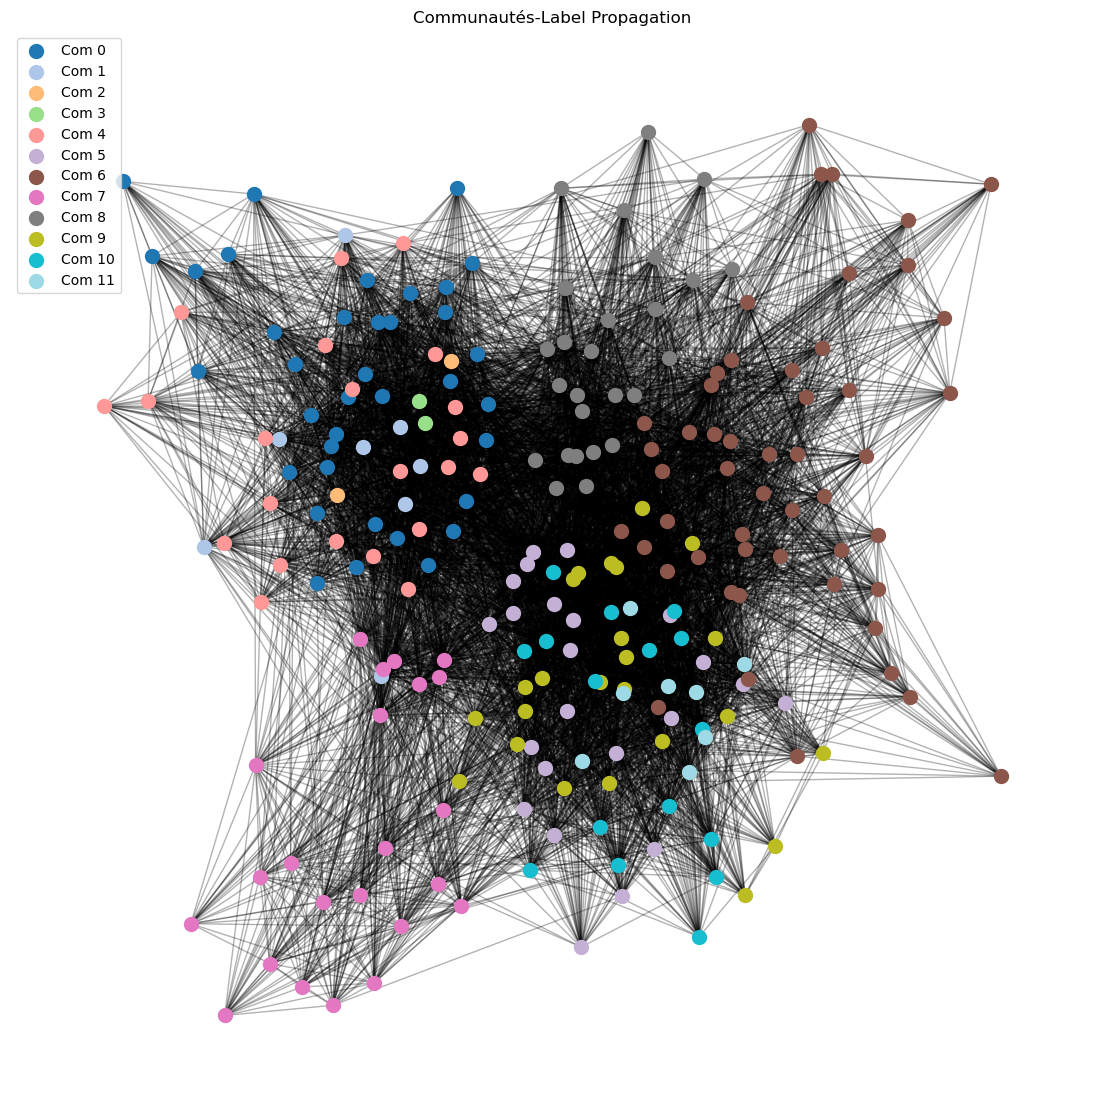

In [137]:
communities_lp = nx_community.asyn_lpa_communities(G, weight='t', seed=42)
partition_lp = {}
for i, com in enumerate(communities_lp):
    for n in com:
        partition_lp[n] = i
        
comm_categories_propagation = categories_per_community(G, partition_lp)

# Afficher le nombre de categories par commaunauté
for comm, cat_count in comm_categories_propagation.items():
    print(f"Communauté {comm} : ")
    for cat, count in cat_count.items():
        total_nodes=sum(cat_count.values())
        print(f"  {cat} -> {count} individus")

# Visualisation 
def plot_communities(G, partition, title):
    plt.figure(figsize=(14,14))
    pos = nx.spring_layout(G, seed=42)
    communities = set(partition.values())
    colors = cm.get_cmap('tab20', len(communities))
    for i, com in enumerate(communities):
        nodes = [n for n in G.nodes() if partition[n] == com]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(i)], node_size=100, label=f"Com {com}")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.legend()
    plt.show()

plot_communities(G, partition_lp, "Communautés-Label Propagation")




# Dynamique de consensus 

In [138]:
def consensus_dynamics_time_evolution(G, x0=None, times=[0.01, 0.02, 0.05], use_expm_eig=True):
    """
    Solve dx/dt = -L x  (continuous consensus model)
    x(t) = exp(-L t) x0
    Returns dict time -> x_t
    """
    L = nx.laplacian_matrix(G).astype(float)
    n = G.number_of_nodes()
    if x0 is None:
        x0 = np.random.randn(n)
    results = {}
    if use_expm_eig and n <= 2000:
        # diagonaliser L
        L_dense = L.toarray()
        vals, vecs = la.eigh(L_dense)
        for t in times:
            exp_diag = np.diag(np.exp(-vals * t))
            x_t = vecs @ (exp_diag @ (vecs.T @ x0))
            results[t] = x_t
    else:
        # use matrix exponential (could be costly)
        for t in times:
            M = la.expm(-L.toarray() * t)
            results[t] = M @ x0
    return results

consensus_time=consensus_dynamics_time_evolution(G, x0=None, times=[0.1, 1.0, 5.0], use_expm_eig=True)
print(consensus_time)


{0.1: array([-9.77860752e-03, -1.34224852e-02, -9.99702038e-03, -1.15521540e-02,
       -1.73836474e-02, -1.08808991e-02, -8.97160479e-03, -8.74906633e-03,
       -9.33990242e-03, -1.12216045e-02, -3.03256124e-02, -9.35838643e-03,
       -5.69298625e-03, -1.08629840e-02, -7.26751664e-03, -6.35216903e-03,
       -1.12762973e-02, -1.21417926e-02, -6.82564886e-03, -1.43279952e-02,
       -1.82551432e-02, -8.18282387e-03, -6.68528593e-03, -1.03003535e-02,
       -9.82878536e-03, -1.29462532e-02, -1.20330670e-02, -8.67799612e-03,
       -7.69255529e-03, -1.29730658e-02, -8.46790178e-03, -1.28477962e-02,
       -3.54786520e-02, -1.06561088e-02, -7.28611630e-03, -1.34210236e-02,
       -1.80204867e-02, -1.28474878e-02, -1.13706941e-02, -1.13538694e-02,
       -1.62396885e-02, -1.02239202e-02, -4.05124429e-03, -3.23290670e-03,
       -1.54144116e-03, -1.14241832e-02,  9.80435478e-04,  6.45604559e-03,
       -1.08381923e-02, -6.80424323e-03, -8.71081786e-03, -1.50976909e-03,
        5.62666283e

Visualisation de la dynamique

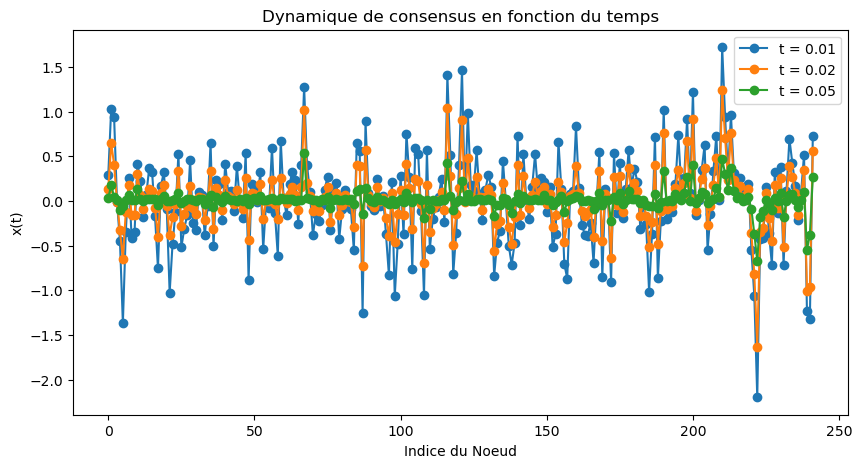

In [139]:
consensus_time = consensus_dynamics_time_evolution(G, times=[0.01, 0.02, 0.05])

plt.figure(figsize=(10,5))

for t, x_t in consensus_time.items():
    plt.plot(x_t, marker='o', label=f"t = {t}")

plt.xlabel("Indice du Noeud")
plt.ylabel("x(t)")
plt.title("Dynamique de consensus en fonction du temps")
plt.legend()
plt.grid(False)
plt.show()


# Marche aleatoire et matrice de transition

In [140]:

def transition_matrix_and_stationary(G):
    A = nx.to_numpy_array(G, dtype=float)
    degs = np.sum(A, axis=1)
    Dinv = np.zeros_like(A)
    nonzero = degs > 0
    Dinv[nonzero, nonzero] = 1.0 / degs[nonzero]
    P = Dinv @ A  # P_ij = prob from i to j
    # stationary distribution for connected undirected graph is pi_i = degree(i) / (2m)
    degs_nodes = np.array([d for n, d in G.degree()])
    pi = degs_nodes / degs_nodes.sum()
  
    return {"P": P, "stationary": pi}

transition_matrix=transition_matrix_and_stationary(G)
print(transition_matrix)

{'P': array([[0.        , 0.01204819, 0.01204819, ..., 0.        , 0.        ,
        0.        ],
       [0.0212766 , 0.        , 0.0212766 , ..., 0.        , 0.        ,
        0.        ],
       [0.01219512, 0.01219512, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]), 'stationary': array([0.00498978, 0.00282554, 0.00492966, 0.00384754, 0.00222436,
       0.00426837, 0.00565108, 0.0023446 , 0.00571119, 0.00456896,
       0.00192377, 0.00577131, 0.00318625, 0.00462907, 0.00667308,
       0.00589155, 0.00378742, 0.00366719, 0.0050499 , 0.00318625,
       0.00276542, 0.00589155, 0.00571119, 0.00486954, 0.00294577,
       0.00390766, 0.00456896, 0.00498978, 0.00637249, 0.00492966,


# Determination de la matrice de contact

In [141]:
class_contact_time = defaultdict(float)

# Grouper par paire de personnes
for (i, j), group in df.groupby([1, 2]):
    Si, Sj = group[3].iloc[0], group[4].iloc[0]  # classes de i et j
    total_t = len(group) * 20  # chaque ligne = 20 secondes de contact
    class_contact_time[(Si, Sj)] += total_t

# Liste des classes uniques
classes = list(set(df[3].unique()).union(set(df[4].unique())))
# Créer une matrice DataFrame
contact_matrix = pd.DataFrame(0, index=classes, columns=classes, dtype=float)
   
# Remplir la matrice
for (c1, c2), t in class_contact_time.items():
    contact_matrix.loc[c1, c2] += t
    if c1 != c2:
        contact_matrix.loc[c2, c1] += t  # symétrie

# Convertir en heures pour lisibilité
contact_matrix = contact_matrix / 3600

# Afficher la matrice
print(contact_matrix)


                 2A         1B         2B         1A         3B         3A  \
2A        50.922222   3.905556  17.805556   5.255556   3.650000   5.655556   
1B         3.905556  93.516667   6.116667   9.711111   1.394444   1.988889   
2B        17.805556   6.116667  62.050000   5.666667   2.994444   6.094444   
1A         5.255556   9.711111   5.666667  37.372222   2.105556   4.344444   
3B         3.650000   1.394444   2.994444   2.105556  57.272222  18.422222   
3A         5.655556   1.988889   6.094444   4.344444  18.422222  47.327778   
4B         0.322222   1.405556   0.266667   1.022222   1.427778   1.255556   
5B         0.194444   2.816667   0.333333   0.616667   1.416667   0.500000   
4A         0.500000   4.516667   0.888889   0.505556   1.961111   0.494444   
5A         0.427778   3.283333   0.244444   0.333333   0.933333   0.672222   
Teachers   5.527778   7.661111   4.122222   1.027778   2.455556   3.361111   

                 4B         5B         4A         5A  Teachers 